# Applied Data Analysis - Impact of conflicts on African civilian population

### Abstract

The age of information makes it seem as though conflict and wars are, and always will be, ever growing part of our lives. We often feel overwhelmed by the amount and scope of information that is accessible and directed towards us, in turn rendering us indifferent to the consequences and casualties of the war.

Civilians are the greatest casualty of any war, and casualties are not always measured in body count. Civil liberties and political freedoms are and should be enjoyed by the people from all around the world, and conflicts always bring changes to freedom of expression, for better or worse.

In this project we want to focus on the continent of Africa, which we feel is underreported in the context of occurring conflicts and casualties. We will utilize UDCP dataset documenting individual events of organized violence, empowered by the Freedom House 'Freedom in the World' yearly surveys and the Human Development Index as measured by the UN.

Our goal is to produce a report with an overarching story about impacts of conflicts on the African continent in the observed period from 1990 to 2015, with the focus on civilian populations - what are the long term consequences that conflicts have on the development of the civilian population.

### Libraries

In [1]:
import folium
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import seaborn as sns
import zipfile

%matplotlib inline

### Configuration

In [2]:
from IPython.display import IFrame
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None

### Specification of regions and country names

Throughout the project, we will observe African continent through its regions as defined by [United Nations' geoscheme for Africa](https://en.wikipedia.org/wiki/United_Nations_geoscheme_for_Africa). This geoscheme is used by the UN and maintained by the UNSD department for statistical purposes, and defines five regions as follows: Northern Africa, Eastern Africa, Southern Africa, Western Africa and Central Africa. Although multiple definitions of African regions exist, depending on the observed context, we consider earlier definition as relevant and appropriate for our statistical analysis.

Furthermore, our definition of African region diverges from the official geoscheme in the following ways:
* In our analysis we have excluded overseas territories:
    * [Mayotte](https://en.wikipedia.org/wiki/Mayotte) (French overseas territory)
    * [Reunion](https://en.wikipedia.org/wiki/Réunion) (French overseas territory)
    * [Saint Helena, Ascension and Tristan da Cunha](https://en.wikipedia.org/wiki/Saint_Helena,_Ascension_and_Tristan_da_Cunha) (British overseas territory)
    
    
* In our analysis we have excluded disputed territories:
    * [Western Sahara](https://en.wikipedia.org/wiki/Western_Sahara)
    
Due to the use of several datasets from several different data sources, some countries have been referenced by different variations on their original name in different datasets. This has resulted in need to adjust names accross datasets. We have used names of countries as specified by the United Nations' geoscheme for Africa as reference accross these datasets, while adjusting any difference when needed.

In [3]:
na_countries = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Sudan',
                'Tunisia']

ea_countries = ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 
                'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique',
                'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Tanzania',
                'Uganda', 'Zambia', 'Zimbabwe']

sa_countries = ['Botswana', 'Lesotho', 'Namibia', 'South Africa', 'Swaziland']

wa_countries = ['Benin', 'Burkina Faso', 'Cabo Verde', 'Cote d\'Ivoire', 'Gambia', 
                'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali',
                'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 
                'Togo']

ca_countries = ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of the Congo',
                'Equatorial Guinea', 'Gabon', 'Republic of the Congo', 'Sao Tome and Principe']

### UCDP dataset

Uppsala Conflict Data Program's georeferenced event dataset, [Global Version 17.1 (2016)](http://www.ucdp.uu.se/downloads/ged/ged171-xlsx.zip), is the central dataset used in our project. Dataset covers individual events of organized violence - phenomena of lethal violence occurring at a given time and place.

>These events are sufficiently fine-grained to be geo-coded down to the level of individual villages, with temporal durations disaggregated to single, individudal days.

There are 135,181 events present in the dataset covering the entirety of the Globe (excluding Syria), spanning from 01/01/1989 to 31/12/2016. Events are futher defined as follows:

>An incident where armed force was by an organised actor against another organized actor, or against civilians, resulting in at least 1 direct death at a specific location and a specific date.

#### Features

UDCP dataset contains many features that thoroughly document occurred events, but not all of which are utilized throughout this project. We will utilize and focus our attention on the following features:
* `year` - The year of the event.
* `type_of_violence` - Type of UCDP conflict:
    * `0` - state-based conflict
    * `1` - non-state conflict
    * `3` - one-sided violence
    
    
* `conflict_name` - Name of the UCDP conflict to which the event belongs.
* `side_a` - The name of side A in the dyad. In state-based conflicts this is always a government. In one-sided violence this is always the perpetrating party.
* `side_b` - The name of side B in the dyad. In state-based conflicts this is always the rebel movement or rivalling government. In one-sided violence this is always “civilians”.
* `country` - Name of the country in which the event took place.
* `region` - Region where the event took place.
* `best_est` - The best (most likely) estimate of total fatalities resulting from an event.

This project makes use of the events which ocurred in the African region throughout the period of 26 years (1990-2015), or roughly 35,437 events. Events documented in the dataset will be aggregated by region, and with information about Human Development Index (HDI), Political Freedom score and Civil Liberties score analyzed and visualized on per-region basis.

#### Adjustment of country names

Following names have been altered in the original UCDP dataset in order to follow earlier established country naming convention accross the project:

| Old country name      | New country name                 |
|:----------------------|:---------------------------------|
| Madagascar (Malagasy) | Madagascar                       |
| Zimbabwe (Rhodesia)   | Zimbabwe                         |
| Ivory Coast           | Cote d'Ivoire                    |
| DR Congo (Zaire)      | Democratic Republic of the Congo |
| Congo                 | Republic of the Congo            |

#### Complete documentation

Full documentation of the used dataset can be obtained [here](http://www.ucdp.uu.se/downloads/ged/ged171.pdf) for further reference.

In [350]:
def read_data():
    '''
    The repo contains the data in a zipped file to save some space,
    this function will automatically extract the csv from that zip,
    if it has not already been extracted, and return the data in a DataFrame.
    '''
    name = './data/ged171'

    # Unzip csv if not unzipped
    if not os.path.isfile(name+'.csv'):
        zip_ = zipfile.ZipFile(name+'.zip', 'r')
        zip_.extractall('./data/')
        zip_.close()

    return pd.read_csv(name+'.csv')

def adjust_country_name(name):
    result = name
    if name == 'Madagascar (Malagasy)':
        result = 'Madagascar'
    elif name == 'Zimbabwe (Rhodesia)':
        result = 'Zimbabwe'
    elif name == 'Ivory Coast':
        result = 'Cote d\'Ivoire'
    elif name == 'DR Congo (Zaire)':
        result = 'Democratic Republic of the Congo'
    elif name == 'Congo':
        result = 'Republic of the Congo'
    return result

df = read_data()
df.country = df.country.apply(adjust_country_name)

df_na = df.loc[df.country.isin(na_countries)]
df_ea = df.loc[df.country.isin(ea_countries)]
df_sa = df.loc[df.country.isin(sa_countries)]
df_wa = df.loc[df.country.isin(wa_countries)]
df_ca = df.loc[df.country.isin(ca_countries)]

### Freedom House dataset

Freedom House is a U.S.-based U.S. Government-funded non-governmental organization (NGO) that conducts research and advocacy on democracy, political freedom, and human rights. Freedom House was founded in October 1941. Organisation describes its goal as:

> We analyze the challenges to freedom, advocate for greater political rights and civil liberties, and support frontline activists to defend human rights and promote democratic change. Founded in 1941, Freedom House was the first American organization to champion the advancement of freedom globally.

The organization's annual *Freedom in the World* report, which assesses each country's degree of political freedoms and civil liberties, is frequently cited by political scientists, journalists, and policymakers.

Organisation's reports on the state of country's political freedoms and civil liberties form our second dataset and can be obtained [here](https://freedomhouse.org/sites/default/files/FIW2017_Data.zip). We will focus our attention on the file `FH_Country_and_Territory_Ratings_and_Statuses_1972-2016.xls` which contains information about political freedom and civil liberties scores for individual countries throughout the period of 1972-2016. Moreover, we are only interested in the scores of African countries throughout the period of 1990-2015.

#### Features

Political rights and civil liberties are measured on a one-to-seven scale, with one representing the highest degree of freedom and seven the lowest. Furthermore, based on the scores assigned for political freedom and civil liberties, Freedom House then designates one of the labels: 'Free', 'Partly Free' and 'Not Free' to each country as an overarching indicator of the state of freedom in that particular country.

#### Evaluation

While there is some debate over the neutrality of Freedom House and the methodology used for the Freedom in the World report, none of the criticisms have demonstrated a systematic bias in all the ratings. For this very reason, as well as high number of citations that Freedom in the World report experiences, we have chosen to proceed with this dataset as the source of relevant indicators on the state of political and civil liberties in the observed countries. Further discussion on the evaluation and its criticism can be found [here](https://en.wikipedia.org/wiki/Freedom_in_the_World#Evaluation).

#### Missing rankings

Through the observed period, several countries have become independent, split into two or more countries, or merged with a neighboring  state. Scores for these countries are given only for the period of their existence as independent states.

#### Adjustment of country names

Following names have been altered in the original Freedom in the World dataset in order to follow earlier established country naming convention accross the project:

| Old country name    | New country name                 |
|:--------------------|:---------------------------------|
| Sao Tome & Principe | Sao Tome and Principe            |
| Congo (Brazzaville) | Republic of the Congo            |
| Congo (Kinshasa)    | Democratic Republic of the Congo |
| Gambia, The         | Gambia                           |
| Cape Verde          | Cabo Verde                       |

#### Separating relevant information

Information relevant for this project
* Political Freedoms score
* Civil liberties score
* Freedom House score

is aggregated by the year of the report. We will split this data in three respective dataframes for the easier use in the future.

In [351]:
fh_path = os.path.join('data', 'Country ratings and statuses.xlsx')
fh_data = pd.read_excel(fh_path, na_values='-')

def fh_adjust_country_name(name):
    result = name
    if name == 'Sao Tome & Principe':
        result = 'Sao Tome and Principe'
    elif name == 'Congo (Brazzaville)':
        result = 'Republic of the Congo'
    elif name == 'Congo (Kinshasa)':
        result = 'Democratic Republic of the Congo'
    elif name == 'Gambia, The':
        result = 'Gambia'
    elif name == 'Cape Verde':
        result = 'Cabo Verde'
    return result

fh_data = fh_data.drop(fh_data.columns[1:52], axis=1)
fh_data = fh_data.iloc[2:]
fh_data[fh_data.columns[0]] = fh_data[fh_data.columns[0]].apply(fh_adjust_country_name)

political_rights = pd.DataFrame()
political_rights['Country'] = fh_data[fh_data.columns[0]]
pr_index = 1 + 0

civil_liberties = pd.DataFrame()
civil_liberties['Country'] = fh_data[fh_data.columns[0]]
cl_index = 1 + 1

fh_status = pd.DataFrame()
fh_status['Country'] = fh_data[fh_data.columns[0]]
fhs_index = 1 + 2

year = 1990

for i in range(26):
    political_rights[year] = fh_data[fh_data.columns[pr_index]]
    civil_liberties[year] = fh_data[fh_data.columns[cl_index]]
    fh_status[year] = fh_data[fh_data.columns[fhs_index]]
    
    pr_index += 3
    cl_index += 3
    fhs_index += 3
    year += 1
    
# Divide by region on political freedoms
political_rights_na = political_rights[political_rights['Country'].isin(na_countries)]
political_rights_ea = political_rights[political_rights['Country'].isin(ea_countries)]
political_rights_sa = political_rights[political_rights['Country'].isin(sa_countries)]
political_rights_wa = political_rights[political_rights['Country'].isin(wa_countries)]
political_rights_ca = political_rights[political_rights['Country'].isin(ca_countries)]

# Divide by region on civil liberties
civil_liberties_na =  civil_liberties[civil_liberties['Country'].isin(na_countries)]
civil_liberties_ea =  civil_liberties[civil_liberties['Country'].isin(ea_countries)]
civil_liberties_sa =  civil_liberties[civil_liberties['Country'].isin(sa_countries)]
civil_liberties_wa =  civil_liberties[civil_liberties['Country'].isin(wa_countries)]
civil_liberties_ca =  civil_liberties[civil_liberties['Country'].isin(ca_countries)]

# Divide by region on Freedom House's score
fh_status_na =  fh_status[fh_status['Country'].isin(na_countries)]
fh_status_ea =  fh_status[fh_status['Country'].isin(ea_countries)]
fh_status_sa =  fh_status[fh_status['Country'].isin(sa_countries)]
fh_status_wa =  fh_status[fh_status['Country'].isin(wa_countries)]
fh_status_ca =  fh_status[fh_status['Country'].isin(ca_countries)]

### Human Development Index dataset

The Human Development Index (HDI) is a composite statistic (composite index) of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores higher HDI when the lifespan is higher, the education level is higher, and the GDP per capita is higher.

>The origins of the HDI are found in the annual Human Development Reports produced by the Human Development Reports Office of the United Nations Development Programme (UNDP). These were devised and launched by Pakistani economist Mahbub ul Haq in 1990, and had the explicit purpose "to shift the focus of development economics from national income accounting to people-centered policies".

Our final dataset is Human Development report by the UN that includes calculated Human Development Indices for the years 1990 through 2015. Naturally, we are interested in the values associated countries from the African continent.

Human Development Index obtains value in the range [0,1], 1 being best possible value.

#### Missing rankings

Through the observed period, several countries have become independent, split into two or more countries, or merged with a neighboring  state. Scores for these countries are given only for the period of their existence as independent states.

#### Adjustment of country names

Following names have been altered in the original Human Development Index dataset in order to follow earlier established country naming convention accross the project:

| Old country name                   | New country name                 |
|:-----------------------------------|:---------------------------------|
| Congo (Democratic Republic of the) | Democratic Republic of the Congo |
| Congo                              | Republic of the Congo            |
| Tanzania (United Republic of)      | Tanzania                         |

In [352]:
hdi_path = os.path.join('data','Human Development Index (HDI).csv')
hdi_data = pd.read_csv(hdi_path, skiprows=1)

def hdi_adjust_country_name(name):
    result = name
    if name == 'Congo (Democratic Republic of the)':
        result = 'Democratic Republic of the Congo'
    elif name == 'Congo':
        result = 'Republic of the Congo'
    elif name == 'Tanzania (United Republic of)':
        result = 'Tanzania'
    return result

hdi_data.Country = hdi_data.Country.apply(lambda x: hdi_adjust_country_name(x.strip()))

hdi_na = hdi_data[hdi_data['Country'].isin(na_countries)]
hdi_ea = hdi_data[hdi_data['Country'].isin(ea_countries)]
hdi_sa = hdi_data[hdi_data['Country'].isin(sa_countries)]
hdi_wa = hdi_data[hdi_data['Country'].isin(wa_countries)]
hdi_ca = hdi_data[hdi_data['Country'].isin(ca_countries)]

### Map data

Map visualizations throughout the project make use of the `africa.json` file which maps African countries, available under MIT license by the author [David Eldersveld](https://github.com/deldersveld/topojson/blob/master/continents/africa.json). We have performed several modifications to the original file in order to adjust country names to follow naming convention used throughout this project:

| Old country name  | New country name      |
|:------------------|:----------------------|
| Cape Verde        | Cabo Verde            |
| Ivory Coast       | Code d'Ivoire         |
| Guinea Bissau     | Guinea-Bissau         |
| Republic of Congo | Republic of the Congo |

Furthermore, we have not been able to properly display countries Mauritius and Seychelles with our working version of topojson file. For this reason, aforementioned countries have been omitted in the map visualizations, and will be added at a later date.

In [16]:
na_countries_center = [22.989358, 11.861105]
ea_countries_center = [-3.967289, 43.487203]
sa_countries_center = [-25.734728, 24.919672]
wa_countries_center = [16.155142, -3.864663]
ca_countries_center = [4.322669, 19.261304]

africa_geo_path = os.path.join('topojson', 'africa.json')
africa_geo_data = json.load(open(africa_geo_path))

In [19]:
africa = folium.Map(ca_countries_center, zoom_start=4)

africa.choropleth(africa_geo_data,
                  key_on='feature.properties.geounit',
                  fill_color = 'BuGn',
                  fill_opacity = 0.4,
                  line_opacity = 0.2,
                  topojson='objects.continent_Africa_subunits')

africa

## Disclaimer

Further work presents *specification* of our pipeline that we plan to apply to every region as part of our project. Although it lacks polish and more expressive commentary, pipeline in its current state points to soundness, feasability and end goal of our project. 

Graphs presented are not yet polished, and map visualizations will be included in the final report for each region.

## Analysing data using plots

We are interested in how the conflicts impact on the development of a country and the life quality of its habitants, in order to do that we analyze our main dataframe using some plot like the one above: for each region we will look at many features, (e.g.  the number of death, the number of conflicts) and we will try to find a correlation between this data and the development index, and the indicators contained in the 'Freedom-House' dataframe. We decided to no plot any points if the values of the variable that we are analysing is equal to 0.

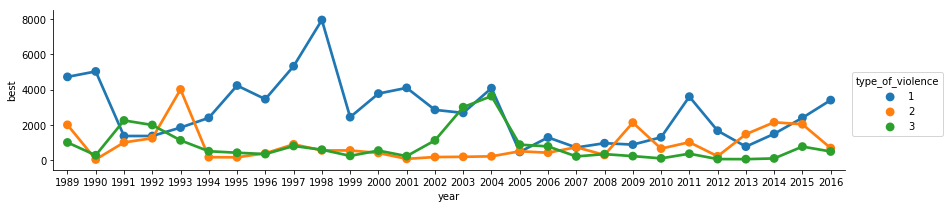

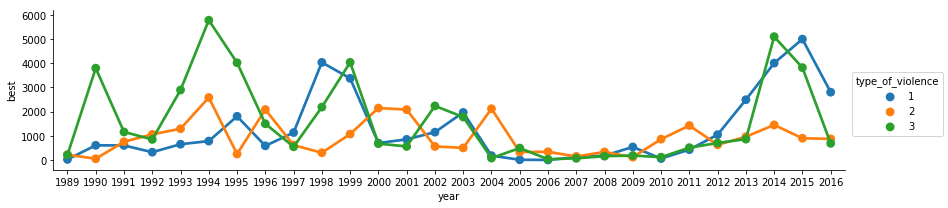

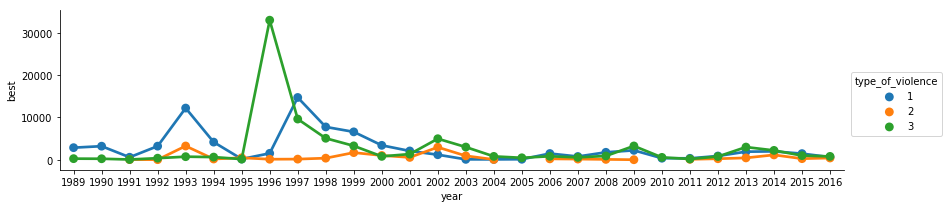

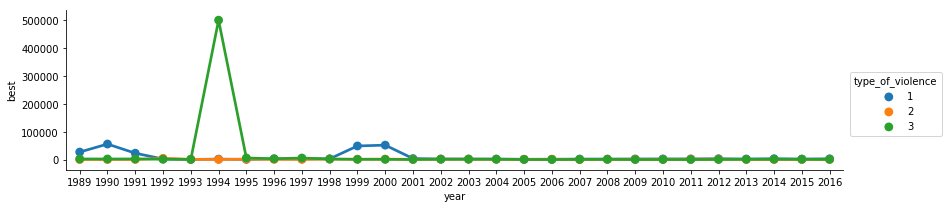

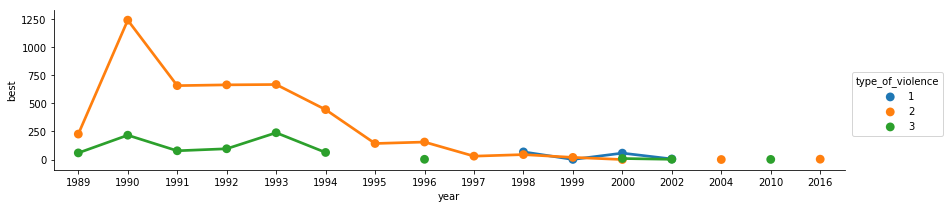

In [353]:
def plot_death_region(data):
    deaths_by_year = data[['year', 'best', 'type_of_violence']] \
        .groupby(['year', 'type_of_violence']) \
        .sum() \
        .reset_index()
    
    g = sns.factorplot(
        x='year', y='best', 
        hue='type_of_violence',
        data=deaths_by_year, 
        kind='point',
        size=3, aspect=4
    )

plot_death_region(df_na)
plot_death_region(df_wa)
plot_death_region(df_ca)
plot_death_region(df_ea)
plot_death_region(df_sa)

After analysing the main dataset, we have defined a function that allows us to change the shape of the other two datasets in order to plot data using Seaborn as before. For each region we compute year by year the average of the indicators that we are considering; thanks this new dataframes we can manipulate, compare and plot data in which we are interested more easily.

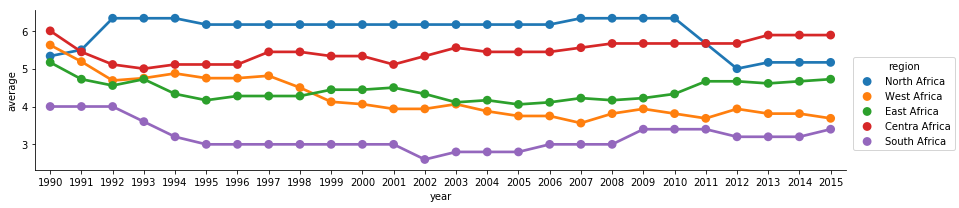

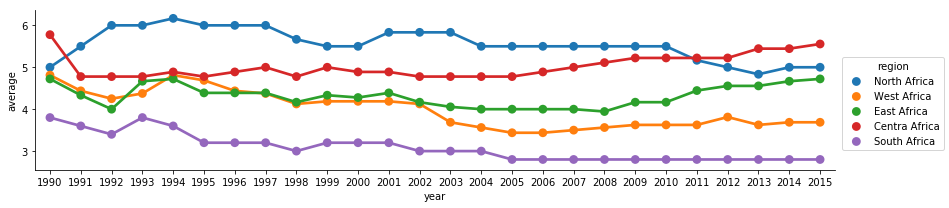

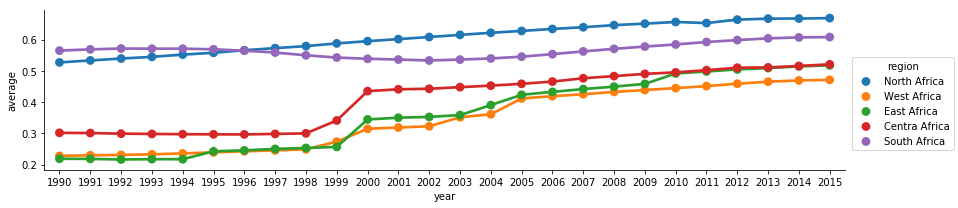

In [354]:
def plot_df(data):
    g = sns.factorplot(
        x='year', y='average', 
        hue='region',
        data=data, 
        kind='point',
        size=3, aspect=4
    )


def transpose_data(data,region,flag):
    n=data.count().Country
    data_t=data.transpose()
    data_t['index']=range(0, data_t.shape[0])
    data_t['average']=data.sum()
    data_t=data_t.set_index('index')
    if flag==0:
        data_t=data_t.drop(0)
    else:
        data_t=data_t.drop([0,1])
    data_t['year']=range(1990, 2016)
    data_t['average']=data_t['average']/n
    data_t['region']=region
    return(data_t)


def merge(na, wa, ea, ca, sa,flag):
    data_merged=pd.merge(transpose_data(na,'North Africa',flag),transpose_data(wa,'West Africa',flag),how='outer')
    data_merged=pd.merge(data_merged,transpose_data(ea,'East Africa',flag),how='outer')
    data_merged=pd.merge(data_merged,transpose_data(ca,'Centra Africa',flag),how='outer')
    data_merged=pd.merge(data_merged,transpose_data(sa,'South Africa',flag),how='outer')
    data_merged=data_merged.dropna(axis=1)
    return(data_merged)

political_rights_plot= merge(political_rights_na,political_rights_wa,political_rights_ea,political_rights_ca,political_rights_sa,0)
civil_liberties_plot=merge(civil_liberties_na,civil_liberties_wa,civil_liberties_ea,civil_liberties_ca,civil_liberties_sa,0)
hdi_plot=merge(hdi_na,hdi_wa,hdi_ea,hdi_ca,hdi_sa,1)

plot_df(political_rights_plot)
plot_df(civil_liberties_plot)
plot_df(hdi_plot)

Comparing the plots above, we can notice that there is a strong correlation between the political rights and the civil liberties score of each region, while human development index has a different trend.
After that we try to define a pipeline to plot on the same graph the data of the main dataset and the tendency of the indicators in order to better compare them graphically.

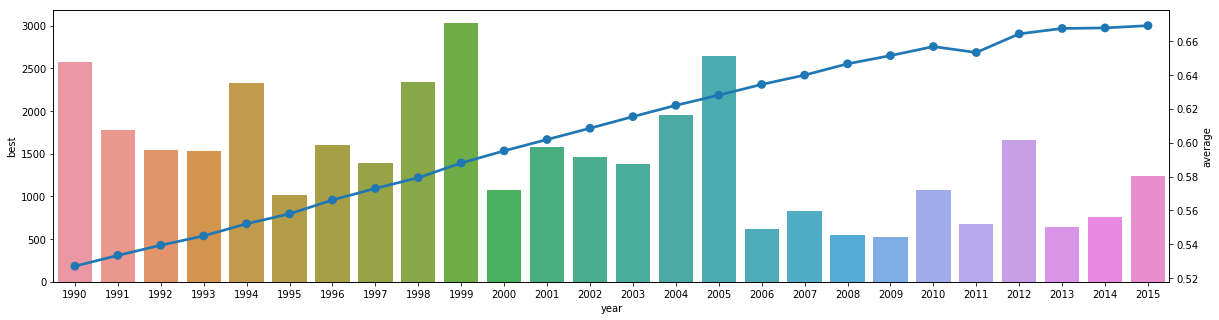

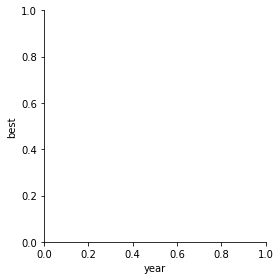

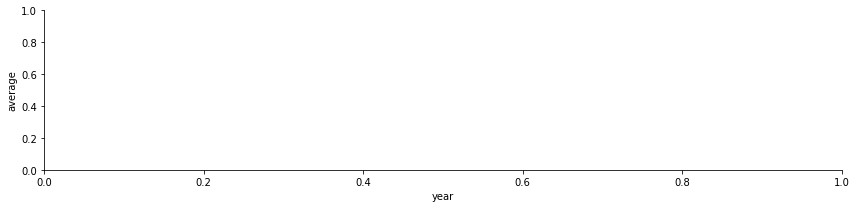

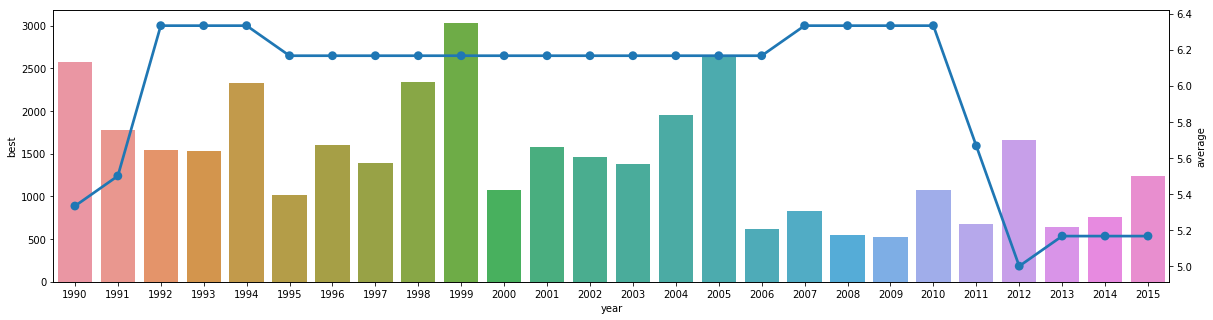

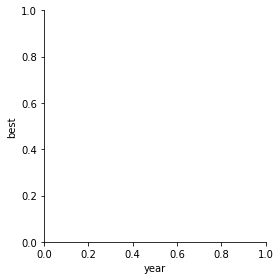

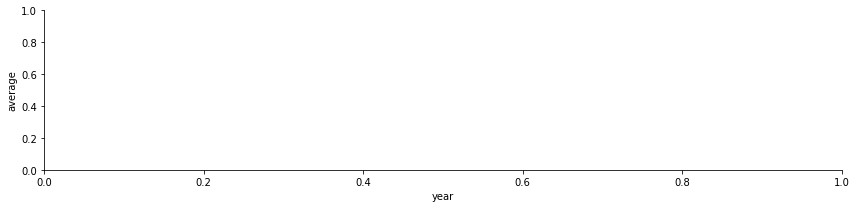

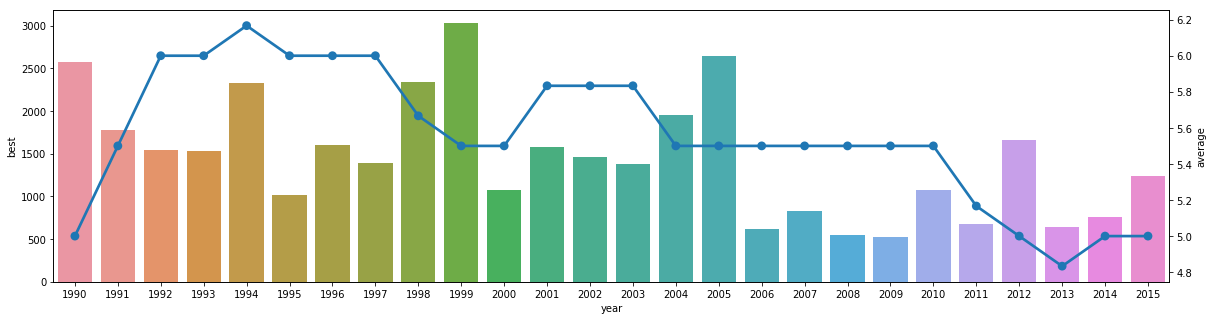

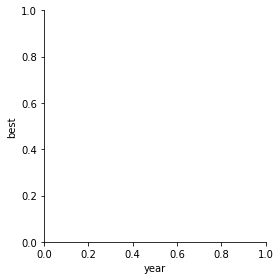

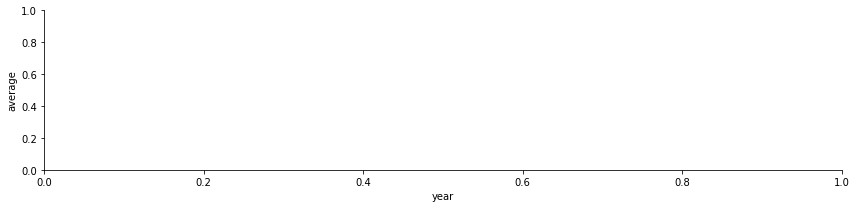

In [355]:
def plot_region(data,region):
    data1 = df_na[['year', 'best', 'type_of_violence']].groupby(['year', 'type_of_violence']).sum().reset_index()
    data2 = data.loc[data.region==region]
    fig, ax = plt.subplots(figsize=(20,5))
    sns.factorplot(
        x='year', y='best', 
        data=data1, ci=None,
        kind='bar', ax=ax)
    ax2 = ax.twinx()
    sns.factorplot(
        x='year', y='average', 
        data=data2,
        kind='point',
        size=3, aspect=4,ax=ax2)
    
plot_region(hdi_plot,'North Africa')
plot_region(political_rights_plot,'North Africa')
plot_region(civil_liberties_plot,'North Africa')

Using these plots, our aim is to find a correlation between the indicators and the magnitude of conflicts (e.g. in term of number of deaths or number of conflicts), moreover we decide to do this analysis region by region in order to see if there are difference between them or if they present any type of correlation, which could be both negative or positive.

### Adaptaions

When researching possible correlation between the number/impact of conflicts and the freedom of expression, we will include an approach where only conflicts where government is present as one of the waring parties, to see whether correlation strengthens (or not). We base this assumption on the fact that governments are those who have the largest capacity to impact different forms of freedom of expression.

### Visualization

Regional approach to research will be enriched with layered map visualizations.